# Smart Charging Using Reinforcement Learning

In [185]:
import math
import numpy as np
import gym
from gym import Env
from gym.spaces import Discrete, Box
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [218]:
class EVChargingEnvironment(Env):
    def __init__(self):
        self.action_space = Discrete(NUM_ACTIONS)
        self.battery_limit = BATTERY_LIMIT
        self.battery_level = self.battery_limit
        self.energy_demand = 0

        # A state in the environment consists of battery level and time interval
        self.observation_space = np.array([Box(low=np.array([0]), high=np.array([self.battery_limit])), Box(low=np.array([0]), high = np.array([8]))])

        # Initialize first state
        self.current_time_index = 0
        self.state = np.array([self.battery_level, self.current_time_index])

        # Set time coefficient as defined above
        self.time_coefficients = [0.9, 0.91, 0.93, 0.94, 0.96, 0.97, 0.99, 1.0]

        # Charging rates in range 0, 7, 14, 22 kWh divided by 4 (because we charge only 15 minutes)
        self.charging_rates = [0, 1.75, 3.5, 5.5]
        self.charging_rates_scaled = [0, 0.25, 0.5, 1]

    def step(self, action):

        charging_rate = self.charging_rates[action]
        charging_rate_scaled = self.charging_rates_scaled[action]


        if self.battery_level + charging_rate > self.battery_limit:
            self.battery_level = self.battery_limit
        else:
            self.battery_level += charging_rate

        reward = self.time_coefficients[self.current_time_index] * math.exp(charging_rate_scaled) * (-1)
        reward = round(reward, 2)

        if charging_rate == 0:
            reward = 0

        self.current_time_index += 1

        # Update time index
        self.state[0] = int(self.battery_level)
        self.state[1] = self.current_time_index
    
        # Check if simulation is complete
        done = self.current_time_index == 8

        if done:
            # Get energy demand from normal distribution
            self.energy_demand = np.random.normal(30, 5)

            if self.battery_level < self.energy_demand:
                # We set a very high penalty of 10,000 because of the cost function resulting in high costs
                reward -= 1000

            self.battery_level = 0

        return self.state, reward, done, {}

    def reset(self):
        self.current_time_index = 0
        self.state = np.array([int(self.battery_level), self.current_time_index])
        return self.state

### Check Environment Functionality

In [219]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()

episodes = 1000

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward

        print(f"Action: {action} | New State: {n_state} | Reward: {reward} | Done: {done}")
    
    print(f"Episode {episode} - Score: {round(score,2)}\n{'*' * 50}")


Episode 1
Initial State: [58  0]
Action: 3 | New State: [58  1] | Reward: -2.45 | Done: False
Action: 2 | New State: [58  2] | Reward: -1.5 | Done: False
Action: 2 | New State: [58  3] | Reward: -1.53 | Done: False
Action: 1 | New State: [58  4] | Reward: -1.21 | Done: False
Action: 3 | New State: [58  5] | Reward: -2.61 | Done: False
Action: 2 | New State: [58  6] | Reward: -1.6 | Done: False
Action: 1 | New State: [58  7] | Reward: -1.27 | Done: False
Action: 1 | New State: [58  8] | Reward: -1.28 | Done: True
Episode 1 - Score: -13.45
**************************************************
Episode 2
Initial State: [0 0]
Action: 0 | New State: [0 1] | Reward: 0 | Done: False
Action: 0 | New State: [0 2] | Reward: 0 | Done: False
Action: 2 | New State: [3 3] | Reward: -1.53 | Done: False
Action: 0 | New State: [3 4] | Reward: 0 | Done: False
Action: 0 | New State: [3 5] | Reward: 0 | Done: False
Action: 1 | New State: [5 6] | Reward: -1.25 | Done: False
Action: 1 | New State: [7 7] | Rewar

In [222]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, 2)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
    return dqn

NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()

states = env.observation_space.shape
actions = env.action_space.n

model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
training_results = dqn.fit(env, nb_steps=10000, visualize=False, verbose=1)

2023-08-15 15:56:50.556146: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_124_1/kernel/Assign' id:20846 op device:{requested: '', assigned: ''} def:{{{node dense_124_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_124_1/kernel, dense_124_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training for 10000 steps ...
Interval 1 (0 steps performed)


2023-08-15 15:56:52.091093: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_125/BiasAdd' id:20806 op device:{requested: '', assigned: ''} def:{{{node dense_125/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_125/MatMul, dense_125/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-15 15:56:52.762023: W tensorflow/c/c_api.cc:304] Operation '{name:'total_155/Assign' id:21039 op device:{requested: '', assigned: ''} def:{{{node total_155/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_155, total_155/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes a

  992/10000 [=>............................] - ETA: 36s - reward: -125.2078

2023-08-15 15:56:57.619115: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_125_1/BiasAdd' id:20880 op device:{requested: '', assigned: ''} def:{{{node dense_125_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_125_1/MatMul, dense_125_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-15 15:56:58.481565: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_157/AddN' id:21140 op device:{requested: '', assigned: ''} def:{{{node loss_157/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_157/mul, loss_157/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

10000/10000 [==============================] - 253s 25ms/step - reward: -36.4432
done, took 253.080 seconds


### Check learned policy

In [223]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()
final_battery_levels = []
episode_rewards = []
episodes = 1000

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    rewards = 0
    init_battery = state[0]

    learned_policy = []
    #print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        rewards += reward
    
    print(f"Episode {episode} - Init Battery: {init_battery} - Actions: {learned_policy} - Final Battery: {state[0]} - Score: {round(rewards,2)}\n{'*' * 50}")

    
    episode_rewards.append(round(rewards,2))
    final_battery_levels.append(state[0])

Episode 1 - Init Battery: 58 - Actions: [1, 1, 1, 1, 1, 1, 1, 3] - Final Battery: 58 - Score: -11.2
**************************************************
Episode 2 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -1015.51
**************************************************
Episode 3 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -1015.51
**************************************************
Episode 4 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -15.51
**************************************************


Episode 5 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -1015.51
**************************************************
Episode 6 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -15.51
**************************************************
Episode 7 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -1015.51
**************************************************
Episode 8 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -1015.51
**************************************************
Episode 9 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -15.51
**************************************************
Episode 10 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - Score: -15.51
**************************************************
Episode 11 - Init Battery: 0 - Actions: [3, 0, 1, 1, 3, 3, 3, 3] - Final Battery: 31 - 

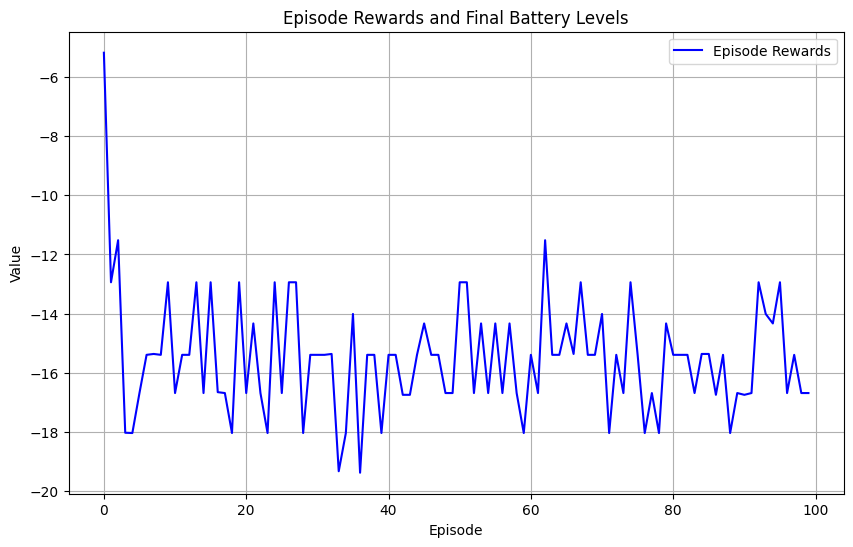

In [210]:
# Plot episode rewards and final battery levels on the same plot
plt.figure(figsize=(10, 6))

# Plot episode rewards
plt.plot(episode_rewards, color='blue', label='Episode Rewards')

plt.title('Episode Rewards and Final Battery Levels')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [211]:
num_episodes = 1000

states = []
all_scores = []

for episode in range(num_episodes):
    learned_policy = []
    scores = 0
    state = env.reset()
    initial_battery_state = state[0]
    done = False
    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        scores += reward
    if (initial_battery_state == 0) | (initial_battery_state > 30):
        print(f"Episode {episode + 1}: Initial Battery state: {initial_battery_state}")
        print(f"Episode {episode + 1}: Learned Policy: {learned_policy}")
    #print(f"Episode {episode + 1}: Score: {scores}")
    #print(f"Episode {episode + 1}: Final battery level: {state[0]}") 
    states.append(state[0])
    all_scores.append(scores)



Episode 201: Initial Battery state: 0
Episode 201: Learned Policy: [3, 3, 3, 3, 3, 3, 3, 3]
Episode 385: Initial Battery state: 0
Episode 385: Learned Policy: [3, 3, 3, 3, 3, 3, 3, 3]
Episode 672: Initial Battery state: 0
Episode 672: Learned Policy: [3, 3, 3, 3, 3, 3, 3, 3]
Episode 790: Initial Battery state: 33
Episode 790: Learned Policy: [0, 1, 1, 1, 1, 1, 1, 3]


In [198]:
results = dqn.test(env, nb_episodes=150, visualize=False, verbose=0)
print(np.mean(results.history['episode_reward']))

-15.597133333333334
